In [1]:
import caiman as cm
import numpy as np
import matplotlib.pyplot as plt
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf, params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.utils.visualization import view_quilt

In [2]:
movie_path = "C:/Users/sangeetha/Courses/Intro-To-Calcium-Imaging-Analysis/data/Sue_2x_3000_40_-46.tif"
print(movie_path)

C:/Users/sangeetha/Courses/Intro-To-Calcium-Imaging-Analysis/data/Sue_2x_3000_40_-46.tif


In [3]:
movie_orig = cm.load(movie_path)
cm.play_movie(movie_orig, plot_text=True)

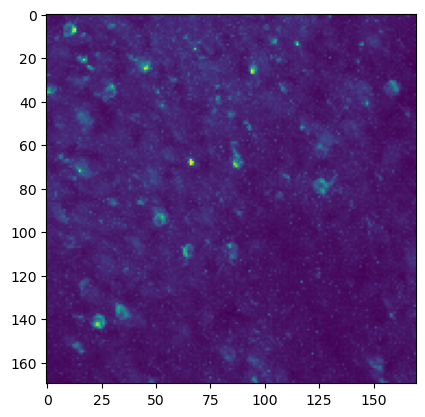

In [4]:
# Summary images of the movie (maximum projection)
max_proj = np.max(movie_orig, axis=0)
plt.imshow(max_proj)

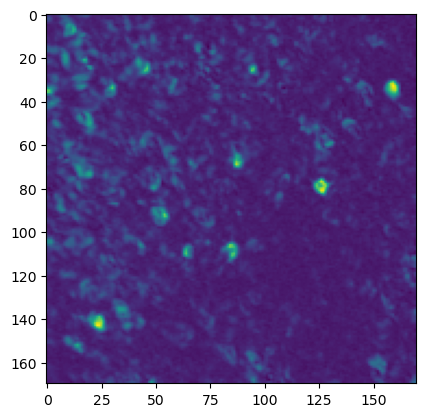

In [5]:
# Summary images (Correlation image)
corr_img = cm.local_correlations(movie_orig, swap_dim=False)
plt.imshow(corr_img)

In [6]:
mc = MotionCorrect(movie_path)
mc.motion_correct(save_movie=True)

c:\Users\sangeetha\anaconda3\envs\caiman\lib\site-packages\caiman\motion_correction.py:3118: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)


In [7]:
movie_corr = cm.load(mc.mmap_file)
cm.play_movie(movie_corr)

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


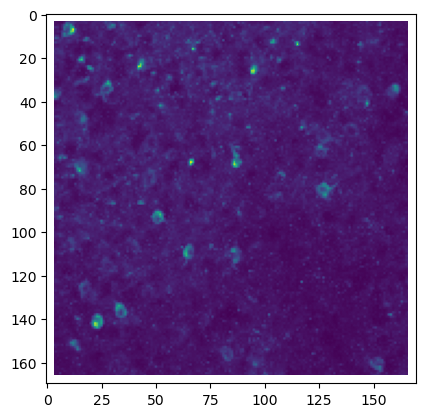

In [8]:
# Summary images of the movie (maximum projection)
max_proj_corr = np.max(movie_corr, axis=0)
plt.imshow(max_proj_corr)

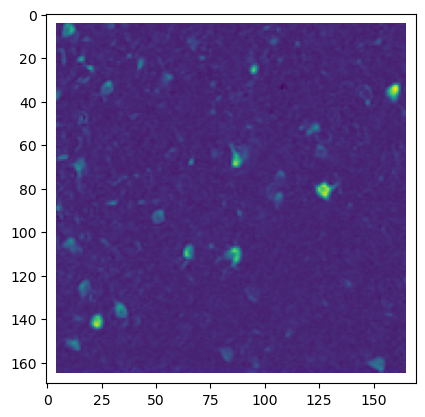

In [9]:
# Summary images (Correlation image)
corr_img_corr = cm.local_correlations(movie_corr, swap_dim=False)
plt.imshow(corr_img_corr)

In [10]:
parameter_dict = {'fnames': movie_path,
                  'fr': 30,
                  'dxy': (2., 2.),
                  'decay_time': 0.4,
                  'strides': (48, 48),
                  'overlaps': (24, 24),
                  'max_shifts': (6, 6),
                  'max_deviation_rigid': 3,
                  'pw_rigid': True,
                  'p': 1,
                  'nb': 2,
                  'rf': 15,
                  'K': 4, 
                  'gSig': np.array([4, 4]),
                  'gSiz': 2*np.array([4, 4]) + 1,
                  'stride': 10,
                  'method_init': 'greedy_roi',
                  'rolling_sum': True,
                  'only_init': True,
                  'ssub': 1,
                  'tsub': 1,
                  'merge_thr': 0.85, 
                  'bas_nonneg': True,
                  'min_SNR': 2.0,
                  'rval_thr': 0.85,
                  'use_cnn': True,
                  'min_cnn_thr': 0.99,
                  'cnn_lowest': 0.1}

parameters = params.CNMFParams(params_dict=parameter_dict) # CNMFParams is the parameters class

In [11]:
cnmf_model = cnmf.CNMF(n_processes=1, params=parameters)

Patch width: 31 , Stride: 20, Overlap: 11


<Axes: >

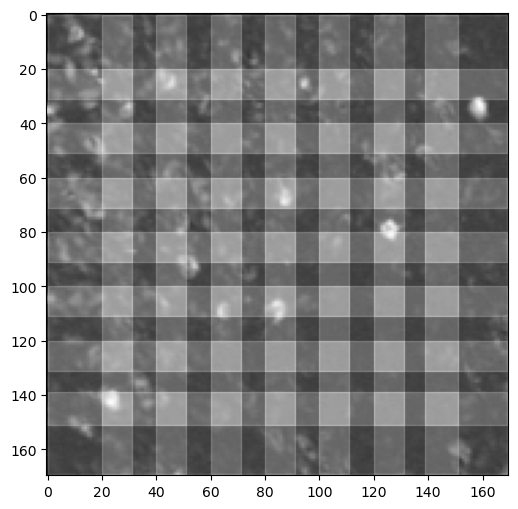

In [12]:
cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride  = cnmf_patch_width - cnmf_patch_overlap
print(f'Patch width: {cnmf_patch_width} , Stride: {cnmf_patch_stride}, Overlap: {cnmf_patch_overlap}');

view_quilt(
    corr_img,
    cnmf_patch_stride,
    cnmf_patch_overlap,
)

In [13]:
border_to_0 = 0 if mc.border_nan == 'copy' else mc.border_to_0 # trim border against NaNs
mc_memmapped_fname = cm.save_memmap(mc.mmap_file, 
                                        base_name='memmap1_', 
                                        order='C',
                                        border_to_0=border_to_0,  
                                    )
Yr, dims, num_frames = cm.load_memmap(mc_memmapped_fname)
images = np.reshape(Yr.T, [num_frames] + list(dims), order='F')


In [14]:
cnmf_fit = cnmf_model.fit(images)
cnmf_fit.estimates.plot_contours_nb(img=corr_img);

In [15]:
# Refit 
cnmf_refit = cnmf_fit.refit(images)
cnmf_refit.estimates.A.shape, cnmf_refit.estimates.C.shape
# A is spatial components and C is denoised calcium traces

((28900, 162), (162, 3000))

In [16]:
print("Thresholds to be used for evaluate_components()")
print(f"min_SNR = {cnmf_refit.params.quality['min_SNR']}")
print(f"rval_thr = {cnmf_refit.params.quality['rval_thr']}")
print(f"min_cnn_thr = {cnmf_refit.params.quality['min_cnn_thr']}")

Thresholds to be used for evaluate_components()
min_SNR = 2.0
rval_thr = 0.85
min_cnn_thr = 0.99


In [17]:
cnmf_refit.estimates.evaluate_components(images, cnmf_refit.params);

GPU run not requested, disabling use of GPUs
USING MODEL (keras API): C:\Users\sangeetha\caiman_data\model\cnn_model.json
6/6 [==============================] - 0s 12ms/step


In [18]:
print(f"Num accepted/rejected: {len(cnmf_refit.estimates.idx_components)}, {len(cnmf_refit.estimates.idx_components_bad)}")

Num accepted/rejected: 64, 98


In [19]:
cnmf_refit.estimates.plot_contours_nb(img=corr_img, 
                                      idx=cnmf_refit.estimates.idx_components);

In [21]:
cnmf_refit.estimates.nb_view_components(img=corr_img, 
                                        idx=cnmf_refit.estimates.idx_components,
                                        cmap='gray');